# Estimating Size: A Hieararchical Approach

In [248]:
import numpy as np
import pandas as pd 
import bokeh.io
import bokeh.plotting
import scipy.stats
import matplotlib.pyplot as plt
import bebi103
import arviz
import cmdstanpy
import size.viz
cor, pal = size.viz.bokeh_style()
_ = size.viz.matplotlib_style()
bokeh.io.output_notebook()

Loading BokehJS ...

In this notebook, I will outline the hieararchical modeling approach we take to estimate the dimensional parameters of microbial cells, namely the width $\omega$, the length $\ell$, and the volume $V$. I will begin with a brief outline of the general approach of hieararchical modeling, followed by specific details and troubleshooting of applying a hierarchical model to size data.

## Defining a Probabalisic Framework
Here, I will always take a Bayesian definition of probability. That is to say that the distribution $P(A)$ reflects the plausability of $A$. It is a measure of the *degree of belief* in $A$, which can be any logical proposition. This allows us to quantify our knowledge of the phenomena we are interested in *without* examining the data to supply the plausibility of a given parameter having a range of values. This is distinctly different than in the frequentist definition of probability where parameters are fixed, and we can only examine how repeats of the phenomenon convert the parameter to something measurable. 

We will assert that probabilities can be summed, such that 
$$P(A) + P(B) + P(\neg A,\neg B) = 1 \tag{sum rule},$$

and multiplied,
$$P(A,B) = P(A\vert B) P(B), \tag{product rule}$$
where the conditional probability is denoted using a conditional operator ($\vert$). In plain English, the sum rule states that the probability of any observation occuring must be equal to 1 and the product rule states that the probability of two events occuring is equal to event $A$ occuring given that $B$ occurred multiplied by the probability that event $B$ has occurred. These two rules will be important in defining the quantitity we are often interested in, $P(A\vert B)$.

### Deriving Bayes' Theorem
Let's say that we are interested in estimating the probability distribution of a parameter $\theta$, given a measurement $y$, and all prior information $I$ about the experiment. Using a Bayesian definition of probability, we can say via the product rule that the probability of observing the parameter $\theta$ at a given value with a given measurement $y$ follows
$$
P(\theta, y \vert I) = P(\theta \vert y, I) P (y \vert I). \tag{1}
$$

By the product rule, we know that
$$
P(\theta, y) = P(y, \theta) = P(y \vert \theta, I) P( \theta \vert I). \tag{2}
$$

Given that we want to estimate the values of parameters given measurements, we ultimately wish to quantify $P(\theta \vert y, I)$. From Eqs. 1 and 2, we can compute this quantity directly as 
$$
P(\theta \vert y, I) = \frac{P(\theta \vert y, I) P(\theta\vert I)}{P(y \vert I)}, \tag{3}
$$

which is known as **Bayes' theorem** . Here, the quantity $P(\theta \vert y, I)$ is termed the *posterior distribution* and reflects our degree of belief in a value of $\theta$ given a measurement $y$ and all prior information $I$. The term in the numerator $P(y \vert \theta, I)$ is termed the *likelihood* and codifies the probability of observing the measurement $y$ given the value of $\theta$ and all other information. This is multiplied by the *prior distribution* $P(\theta\vert I)$ which represents our knowledge of the values $\theta$ *may* take while remaining completely ignorant of the data $y$. The denominatory $P(y\vert I)$ is known as the evidence and, for the purposes of this project, will be considered to be a normalization constant and not explicitly defined.

### Defining Notation
When speaking generally about hierarchical modeling, I will always denote a single parameter as $\theta$  and a set of parameters as $\{\theta\}$. Similarly, I will consider a single datum to be $y$ and a set of data to be $\{y\}$. As I will assume that science is not being performed in a vacuum, I will also drop the notation of $I$, but know that it is assumed to always be present. 

Finally, as $P(\dots)$ can be an overloaded term, I will refer to probability distributions over parameters and data to be denoted by $f$ and $g$, respectively, with the conditional probability $P(\theta\vert y)P(\theta) = \pi(\theta, y).$ For clariy, Eq. 3 can be rewritten using this notation as 
$$
g(\theta\vert y) = \frac{f(y\vert \theta)g(\theta)}{f(y)} = \frac{\pi(\theta, y)}{f(y)}. \tag{4}
$$

## Building a Probabilistic Model
### Defining the Posterior Distribution
Before we jump into the details of hierarchical models, let's begin by considering how we would infer average cell shape parameters (width $\mu_\omega$ and length $\mu_\ell$) from a collection of $n$ *single cell* measurements. To keep things simple, we will first model a single biological replicate. We will define the data as the set of quantities 
$$
\{\omega\} = \{\omega_1, \omega_2, \dots, \omega_n\}, \tag{5, width}
$$
$$
\{\ell\} = \{\ell_1, \ell_2, \dots,\ell_n\}, \tag{6, length}.
$$ 

Given inferred population average width $\mu_\omega$ and length $\mu_\ell$, the population average volume $V^*$ can be calculated assuming a $z$-symmetric spherocylinder as 
$$
V(\omega, \ell) = \frac{\pi}{12}\omega^2(3 \ell - \omega) \tag{7}.
$$

From the set of measurements, we are interested in evaluating the posterior distribution $g(\mu_\omega, \mu_\ell \vert \{\omega\}, \{\ell\})$. To do so, I will make the assumption that in a given experimental condition, the width and length are independent. Via Bayes' theorem (Eq. 3), we can then say 
$$
g(\mu_\omega, \mu_\ell, \vert \{\omega\}, \{\ell\}) \propto \pi(\mu_\omega, \{\omega\})\pi(\mu_\ell,\{\ell\}), \tag{8}
$$
where the proportionality arises from neglecting the evidence $f(\{\omega\}, \{\ell\})$ as a normalization constant. 

Recalling that a joint distribution $\pi(\theta, y)$ represents the product of the likelihood $f(y\vert \theta)$ and the prior $g(\theta)$, we now turn our attention to defining these distributions. 

### Defining the Likelihood
We begin by defining the likelihood distributions, $f(\{\omega\}\vert \mu_\omega)$ and $f(\{\ell\}\vert \mu_\ell)$.  While not entirely correct, we can make the reasonable assumption that these two parameters (within a given condition) are independently distributed, allowing us to separate their likelihoods. This is not perfectly correct because (i) we know that across a wide range of growth rates, theres is a positive correlation between average width and length and (ii) cells divide by binary fission, and thus the daughters inherit the width of the mother cell. We consider the the first effect to be negligible as the distribution of growth rates *within a single condition* to be well constrained, especially compared to the range of growth rates observed between conditions. We assume the second consideration is largely negligible as our experimental system is well mixed, meaning that the probability of observing only one lineage in a given dataset is vanishingly small. 
#### Width
We definine rod-shaped growth as occuring only along the cells' long axis, meaning that the cell ellongates and eventually pinches off into two approximately equal sized daughter cells.  Under this assumption, the cell width should not change throughout the cell cycle. Thus, it is reasonable to consider that the single-cell widths should be normally distributed with a mean $\mu_\omega$ and a standard deviation $\sigma_\omega$. The likelihood for the width distribution is therefore defined as
$$
f(\{\omega\}\vert \mu_\omega, \sigma_\omega) = \frac{1}{\left(2\pi\sigma_\omega^2\right)^{n/2}} \prod\limits_i^n \exp\left\{-\frac{(\omega_i - \mu_\omega)^2}{2 \sigma_\omega^2} \right\}. \tag{9}
$$

For notational simplicity, we will abbreviate this to the form 
$$
f(\{\omega\}\vert \mu_\omega, \sigma_\omega) \sim \text{Normal}(\mu_\omega, \sigma_\omega) \tag{10}.
$$

#### Length
Defining the likelihood for the length distribution is a bit more tricky.  We must now consider how the cell lengths are distributed knowing that the older a cell is, the longer it appears. This means that the cell length will be correlated with the cell age. To a first approximation, there should be twice as many newborn cells as cells that are at their terminal length, meaning we cannot simply make an approximation that the cell lengths will be normally distributed. We therefore must have an expression for (i) the *age* distribution of cells and (ii) an expression for how the cell length changes over a cell cycle. These are expressions that have been derived *ad nauseum* in the literature, and as such we state them here. The age $a$ distribution given a doubling time $\tau$ follows
$$
f(a \vert \tau) = \frac{2 \log 2}{\tau}2^{-a / \tau} \tag{11}.
$$

Assuming that cell length grows exponentially with the cell age, we can say that the probability density function for length $\ell$ is 
$$
f(\ell \vert \ell_{div}) = \begin{cases}\frac{\ell_{div}}{\ell^2} \,\text{if}\, \frac{\ell_{div}}{2} \leq \ell \leq \ell_{div} \\ 0 \,\text{otherwise}\end{cases} \tag{11}.
$$

where $\ell_{div}$ is the division length and it is assumed that the cell length doubles over the cell cycle (from $\frac{1}{2}\ell_{div}$ to $\ell_{div}$). This is a normalized distribution as the integral over this domain is equal to unity, 
$$
\int\limits_{\ell_{div}/2}^{\ell} \frac{\ell_{div}}{\ell^2} d \ell = \left(\frac{\ell_{div}}{\ell}\right)\bigg\vert_{\frac{\ell_{div}}{2}}^{\ell_{div}} = 1 \tag{12}.
$$

From this distribution, we can calculate the average cell length $\mu_\ell$ as 
$$
\mu_\ell = \left(\ell_{div} - \frac{\ell_{div}}{2}\right) \int\limits_{\ell_{div}/2}^{\ell_{div}}\frac{\ell_{div}}{\ell^2} d\ell = \ell_{div}\log2. \tag{13}
$$

Thus, rather than estimating $\mu_{\ell}$, we simply need to infer $\ell_{div}$. The likelihood for this parameter is then
$$
f(\{\ell\}\vert \ell_{div}) = \ell_{div}^n \prod\limits_i^n \frac{1}{\ell_i^2}. \tag{14}
$$

<div class="alert alert-warning">
I cannot get this to be implemented properly and I'm having trouble rederiving this result for myself. For now, I will proceed with the following changes.
</div>

### Defining the Priors

With the likelihoods in hand, we now need to define the prior distributions over the parameters, which now include $\mu_\omega$, $\sigma_\omega$, and $\ell_{div}$, an inherently subjective matter. This is a good thing! We are forced to very clearly enumerate what our subjective assumptions are regarding the possible values of the paramters. 

What do we know about each of these parameters? We know that 
1. All three parameters must be positive and greater than 0. 
2. The width is not very close to 0. It's reasonable to say that there is a vanishingly low probability that the width is less than 0.1 microns, which is around 50 ribosomes side-to-side. Similarly, we can say that the width is also not likely to be more than a few microns in the most extreme case.
3. The birth length (one-half the division length) cannot be less than the width, or else the dimensions of a rod-shaped cell  is flipped. Likewise, the width cannot be wider than the division length. 

We can now choose probability distributions that satisfy these constraints. I do this by looking at the [probability distribution explorer tool](https://distribution-explorer.github.io/) written by Justin Bois at Caltech. For these parameters,
I chose the prior distributions

$$
g(\mu_\omega) \sim \text{Gamma}(\alpha=6, \beta=4.3), \tag{15}
$$
and 
$$
g(\ell_{div}) \sim \text{Gamma}(\alpha=5.75, \beta=2.5). \tag{16}
$$
for the shape parameters and 
$$
g(\sigma_\omega) \sim \text{HalfNormal}(\sigma=1), \tag{17}
$$ 
for the scale parameter on the width distribution. The PDFs of these distributions are shown in the plots below.

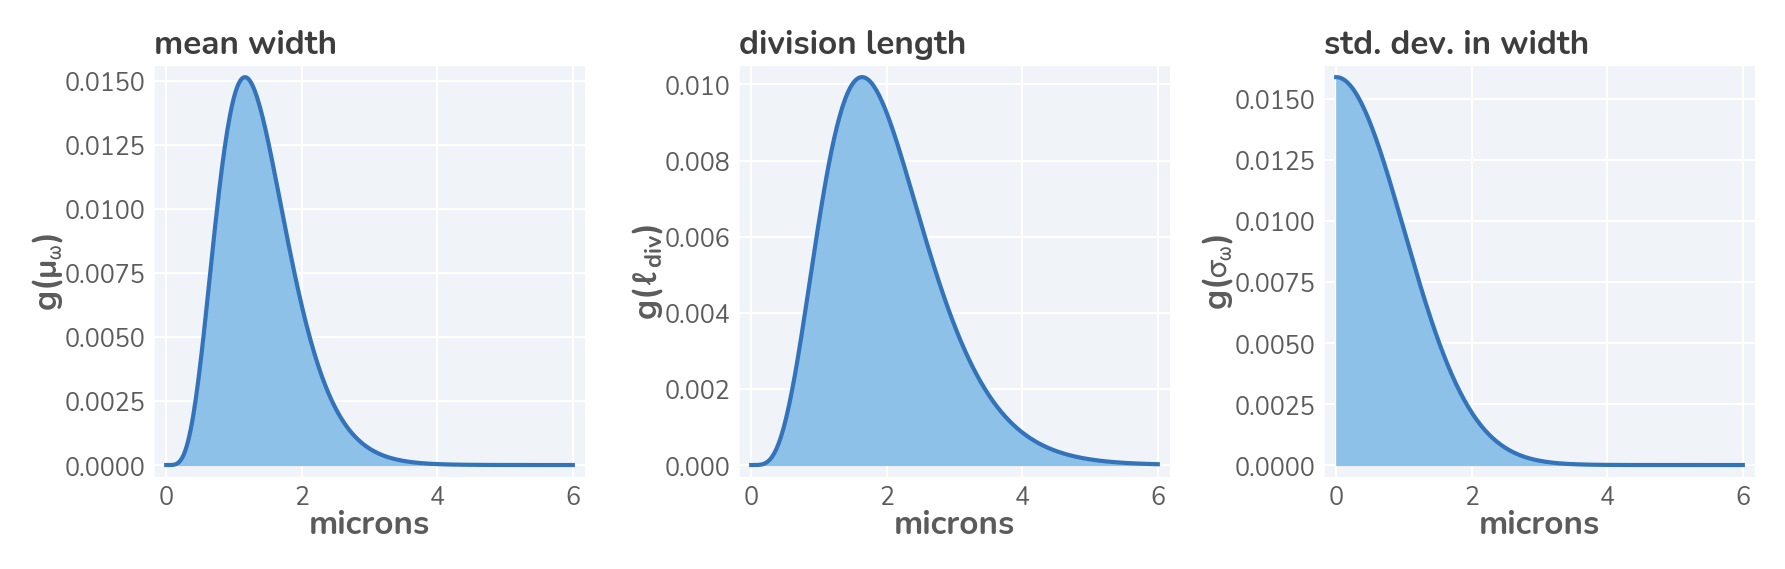

In [249]:
# Define the length scale
microns = np.linspace(0.001, 6, 300)

# Compute the PDFs
mu_width = scipy.stats.gamma(6, loc=0, scale=1/4.3).pdf(microns)
mu_width *= mu_width.sum()**-1
sigma_width = np.sqrt(scipy.stats.norm(loc=0, scale=1).pdf(microns)**2)
sigma_width *= sigma_width.sum()**-1
ell_div = scipy.stats.gamma(5.5, loc=0, scale=1/2.75).pdf(microns)
ell_div *= ell_div.sum()**-1

#Plot 
fig, ax = plt.subplots(1, 3, figsize=(6,2))
ax[0].plot(microns, mu_width, '-', lw=1, color=cor['primary_blue'])
ax[0].fill_between(microns, 0, mu_width, color=cor['pale_blue'])
ax[1].plot(microns, ell_div, '-', lw=1, color=cor['primary_blue'])
ax[1].fill_between(microns, 0, ell_div, color=cor['pale_blue'])
ax[2].plot(microns, sigma_width, '-', lw=1, color=cor['primary_blue'])
ax[2].fill_between(microns, 0, sigma_width, color=cor['pale_blue'])

# Label the axes for clarity
for a in ax:
    a.set_xlabel('microns')
ax[0].set_title('mean width')
ax[1].set_title('division length')
ax[2].set_title('std. dev. in width')
ax[0].set_ylabel('$g(\mu_\omega)$')
ax[1].set_ylabel('$g(\ell_{div})$')
ax[2].set_ylabel('$g(\sigma_\omega)$')
plt.tight_layout()

### Practically Evaluating the Posterior 
The product of  Eq. 9 and Eqs. 14 - 17 yield the complete posterior distribution (unnormalized) for the parameters of interest. This is an intense expression that may not even be solvable analytically. To do so, we would need to marginalize this posterior over each parameter to compute the posterior distribution. 

Luckily, we live in an age where our computers are impressively powered. We can sample the posterior disturibution using Markov chain Monte Carlo, which I will do through the probabilistic programming language [Stan](https://mc-stan.org/). 

In [264]:
single_rep_code = """ 
data { 
    // Define observables
    int<lower=1> N; // Number of measurements
    vector<lower=0>[N] cell_widths;
    vector<lower=0>[N] cell_lengths;
}

transformed data {
    vector<lower=0>[N] cell_volumes = (pi()/12) * cell_widths.^2 .* (3 .* cell_lengths - cell_widths);
}

parameters { 
    //Instantiate the parameters
    real<lower=0> mu_omega;
    real<lower=0> sigma_omega;
    real<lower=0> alpha_ell;
    real<lower=0> beta_ell; 
    real<lower=0> mu_vol;
    real<lower=0> sigma_vol;
}

transformed parameters {
    real<lower=0> mu_ell = alpha_ell / beta_ell;
}

model {
    // Priors
    mu_omega ~ std_normal();
    sigma_omega ~ std_normal(); 
    mu_vol ~ std_normal();
    sigma_vol ~ std_normal();
    alpha_ell ~ normal(0, 5);
    beta_ell ~ normal(0, 5);

    // Likelihoods
    cell_widths ~ normal(mu_omega, sigma_omega);
    cell_lengths ~ gamma(alpha_ell, beta_ell);
    cell_volumes ~ normal(mu_vol, sigma_vol);
}

generated quantities {
    vector[N] omega_rep ;
    vector[N] ell_rep;
    vector[N] vol_rep;
    for (i in 1:N) { 
        omega_rep[i] = normal_rng(mu_omega, sigma_omega);
        ell_rep[i] = gamma_rng(alpha_ell, beta_ell);
        vol_rep[i] = normal_rng(mu_vol, sigma_vol);
    }
}
"""
with open('./single_rep_code.stan', 'w') as file:
    file.writelines(single_rep_code)

single_rep_model = cmdstanpy.CmdStanModel(stan_file='single_rep_code.stan')

14:02:10 - cmdstanpy - INFO - compiling stan file /Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code.stan to exe file /Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code
14:02:17 - cmdstanpy - INFO - compiled model executable: /Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code


With the probabilistic model defined, we can load in the data and evaluate it. 

In [265]:
# Load the size data and restrict to one condition
data = pd.read_csv('../processing/microscopy/wildtype_size_measurement/output/wildtype_size_measurements.csv')
cond = data[(data['carbon_source']=='glucose') & (data['date']=='2021-12-17_')]

# Assemble the data dictionary
data_dict = {'N': len(cond),
             'cell_widths': cond['width_median'].values.astype(float),
             'cell_lengths': cond['length'].values.astype(float)}

# Sample the model
single_rep_samples = single_rep_model.sample(data=data_dict)#, iter_warmup=2000, iter_sampling=3000, adapt_delta=0.9)
single_rep_samples = arviz.from_cmdstanpy(single_rep_samples)

# Run quick diagnostics to make sure everything is okay. 
bebi103.stan.check_all_diagnostics(single_rep_samples)

14:02:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status
chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status


chain 1 |          | 00:00 Status███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 4 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 3 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 3 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3

14:02:21 - cmdstanpy - INFO - CmdStan done processing.
14:02:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: single_rep_code_model_namespace::log_prob: mu_ell is nan, but must be greater than or equal to 0.000000 (in '/Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code.stan', line 24, column 4 to column 48)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code.stan', line 37, column 4 to column 48)
Exception: single_rep_code_model_namespace::log_prob: mu_ell is nan, but must be greater than or equal to 0.000000 (in '/Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code.stan', line 24, column 4 to column 48)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/gchure/Dropbox/git/postdoc_projects/size_control/code/exploratory/single_rep_code.stan', line 37, colu

Effective sample size looks reasonable for all parameters.

Rhat looks reasonable for all parameters.

0 of 4000 (0.0%) iterations ended with a divergence.

0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.

E-BFMI indicated no pathological behavior.


0

In [268]:
p = bebi103.viz.corner(single_rep_samples, parameters=['mu_omega', 'sigma_omega', 'mu_ell', 'mu_vol', 'sigma_vol'])
bokeh.io.show(p)

In [272]:
omega_post_pred_df = single_rep_samples.posterior.omega_rep.to_dataframe().reset_index()
vol_post_pred_df = single_rep_samples.posterior.vol_rep.to_dataframe().reset_index()
ell_post_pred_df = single_rep_samples.posterior.ell_rep.to_dataframe().reset_index()

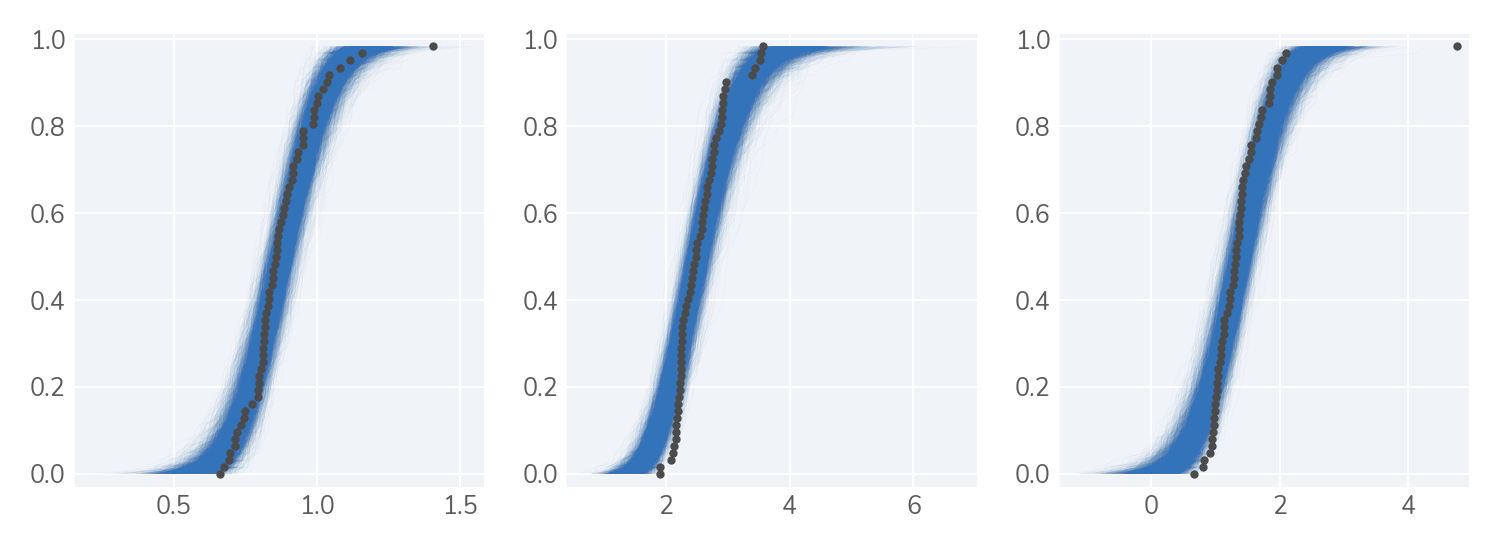

In [274]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2))
i = 0
for g, d in omega_post_pred_df.groupby(['chain', 'draw']):
        _x = np.sort(d['omega_rep']) 
        _y = np.arange(len(d['omega_rep'])) / len(d)
        ax[0].plot(_x, _y, '-', lw=0.1, color=cor['primary_blue'], alpha=0.05)

for g, d in ell_post_pred_df.groupby(['chain', 'draw']):   
        _x = np.sort(d['ell_rep']) 
        _y = np.arange(len(d['ell_rep'])) / len(d)
        ax[1].plot(_x, _y, '-', lw=0.1, color=cor['primary_blue'], alpha=0.05)

for g, d in vol_post_pred_df.groupby(['chain', 'draw']):   
        _x = np.sort(d['vol_rep']) 
        _y = np.arange(len(d['vol_rep'])) / len(d)
        ax[2].plot(_x, _y, '-', lw=0.1, color=cor['primary_blue'], alpha=0.05)

omega_data = cond['width_median'].values
ell_data = cond['length'].values
vol_data = (np.pi / 12) * cond['width_median'].values**2 * (3 * cond['length'] - cond['width_median'])
omega_x = np.sort(omega_data)
ell_x = np.sort(ell_data)
vol_x = np.sort(vol_data)
y = np.arange(len(ell_x)) / len(ell_x)
ax[0].plot(omega_x, y, '.', ms=4, markeredgewidth=0, color=cor['primary_black'])
ax[1].plot(ell_x, y, '.', ms=4, markeredgewidth=0, color=cor['primary_black'])
ax[2].plot(vol_x, y, '.', ms=4, markeredgewidth=0, color=cor['primary_black'])